In [1]:
# ==============================================================================
# SCRIPT TO CALCULATE AND PLOT FIGURE B1 (Pressure-Coordinate Version, Including Latent Heat of Fusion)
# Modified to include a third panel comparing peak T_s with and without fusion.
#
# This script performs the following actions:
# 1. Defines thermodynamic constants and functions for a moist atmosphere, both with and without phase-dependent effects.
# 2. Implements functions to calculate moist adiabatic temperature profiles T(p) for both cases.
# 3. Runs these functions for a dense range of surface temperatures (Ts) and perturbed states to compute warming profiles.
# 4. Processes the results to find peak T_s for each pressure level in both cases.
# 5. Creates a three-panel plot:
#    (a) Vertical profiles of warming (Delta T) vs. pressure (with fusion).
#    (b) Non-monotonic warming at fixed pressure levels vs. surface temp (with fusion).
#    (c) Peak T_s without fusion (x) vs. peak T_s with fusion (y), colored by pressure.
# ==============================================================================

%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy import constants
import time

# --- Physical Constants ---
g = constants.g
cpd = 1005.7
Rd = 287.05
Rv = 461.5
epsilon = Rd / Rv
P0 = 100000.0
Lv = 2.501e6  # Latent heat of vaporization
Lf = 0.334e6  # Latent heat of fusion (standard value; doc approx. 0.33e6)
T0 = 273.16   # Freezing point (K)
T_ice = 250.16  # Ice threshold (K), from ECMWF IFS microphysics

# --- Functions for WITH Fusion ---

def liquid_fraction(T):
    if T >= T0:
        return 1.0
    elif T <= T_ice:
        return 0.0
    else:
        return ((T - T_ice) / (T0 - T_ice)) ** 2

def es_water(T):
    a1 = 611.21
    a3 = 17.502
    a4 = 32.19
    return a1 * np.exp(a3 * (T - T0) / (T - a4))

def es_ice(T):
    a1 = 611.21
    a3 = 22.587
    a4 = -0.7
    return a1 * np.exp(a3 * (T - T0) / (T - a4))

def saturation_vapor_pressure_with(T):
    alpha_liq = liquid_fraction(T)
    es = alpha_liq * es_water(T) + (1.0 - alpha_liq) * es_ice(T)
    return es

def saturation_specific_humidity_with(p, T):
    es = saturation_vapor_pressure_with(T)
    es = np.minimum(es, p * 0.99)
    denominator = p - (1.0 - epsilon) * es
    qs = epsilon * es / denominator
    return np.maximum(qs, 1e-9)

def effective_latent_heat_with(T):
    alpha_liq = liquid_fraction(T)
    return Lv + (1.0 - alpha_liq) * Lf

def virtual_temperature_with(T, p):
    qs = saturation_specific_humidity_with(p, T)
    Tv = T * (1.0 + (1.0 / epsilon - 1.0) * qs)
    return np.maximum(Tv, 10.0)

def calculate_mse_with(T, p, z):
    qs = saturation_specific_humidity_with(p, T)
    L_eff = effective_latent_heat_with(T)
    mse = cpd * T + g * z + L_eff * qs
    return mse

def calculate_profile_with(T_surf, p_surf, p_grid):
    n_steps = len(p_grid)
    T_profile = np.full(n_steps, np.nan)
    z_profile = np.full(n_steps, np.nan)
    T_profile[0] = T_surf
    z_profile[0] = 0.0
    mse_conserved = calculate_mse_with(T_profile[0], p_grid[0], z_profile[0])
    for i in range(n_steps - 1):
        T_curr, p_curr, z_curr = T_profile[i], p_grid[i], z_profile[i]
        p_next = p_grid[i+1]
        if np.isnan(T_curr) or p_curr <= 0: break
        Tv_curr = virtual_temperature_with(T_curr, p_curr)
        alpha_curr = (Rd * Tv_curr) / p_curr
        dz = - (alpha_curr / g) * (p_next - p_curr)
        z_next = z_curr + dz
        
        def mse_residual(T_guess):
            return calculate_mse_with(T_guess, p_next, z_next) - mse_conserved
        
        try:
            bracket = [150.0, T_curr + 10.0]
            if mse_residual(bracket[0]) * mse_residual(bracket[1]) > 0:
                bracket[1] += 20.0
                if mse_residual(bracket[0]) * mse_residual(bracket[1]) > 0: break
            sol = root_scalar(mse_residual, bracket=bracket, method='brentq', xtol=1e-3)
            if sol.converged:
                T_profile[i+1] = sol.root
                z_profile[i+1] = z_next
            else: break
        except (ValueError, RuntimeError): break
    return T_profile

# --- Functions for WITHOUT Fusion ---

def saturation_vapor_pressure_no(T):
    T_celsius = T - 273.15
    es_hPa = 6.112 * np.exp((17.67 * T_celsius) / (T_celsius + 243.5))
    return es_hPa * 100.0

def saturation_specific_humidity_no(p, T):
    es = saturation_vapor_pressure_no(T)
    es = np.minimum(es, p * 0.99)
    denominator = p - (1.0 - epsilon) * es
    qs = epsilon * es / denominator
    return np.maximum(qs, 1e-9)

def virtual_temperature_no(T, p):
    qs = saturation_specific_humidity_no(p, T)
    Tv = T * (1.0 + (1.0 / epsilon - 1.0) * qs)
    return np.maximum(Tv, 10.0)

def calculate_mse_no(T, p, z):
    qs = saturation_specific_humidity_no(p, T)
    mse = cpd * T + g * z + Lv * qs
    return mse

def calculate_profile_no(T_surf, p_surf, p_grid):
    n_steps = len(p_grid)
    T_profile = np.full(n_steps, np.nan)
    z_profile = np.full(n_steps, np.nan)
    T_profile[0] = T_surf
    z_profile[0] = 0.0
    mse_conserved = calculate_mse_no(T_profile[0], p_grid[0], z_profile[0])
    for i in range(n_steps - 1):
        T_curr, p_curr, z_curr = T_profile[i], p_grid[i], z_profile[i]
        p_next = p_grid[i+1]
        if np.isnan(T_curr) or p_curr <= 0: break
        Tv_curr = virtual_temperature_no(T_curr, p_curr)
        alpha_curr = (Rd * Tv_curr) / p_curr
        dz = - (alpha_curr / g) * (p_next - p_curr)
        z_next = z_curr + dz
        
        def mse_residual(T_guess):
            return calculate_mse_no(T_guess, p_next, z_next) - mse_conserved
        
        try:
            bracket = [150.0, T_curr + 10.0]
            if mse_residual(bracket[0]) * mse_residual(bracket[1]) > 0:
                bracket[1] += 20.0
                if mse_residual(bracket[0]) * mse_residual(bracket[1]) > 0: break
            sol = root_scalar(mse_residual, bracket=bracket, method='brentq', xtol=1e-3)
            if sol.converged:
                T_profile[i+1] = sol.root
                z_profile[i+1] = z_next
            else: break
        except (ValueError, RuntimeError): break
    return T_profile

# --- Helper Function for Finding Interpolated Roots (Revised to only include maxima) ---

def find_interpolated_root(y_slice, x_vals, y_slice_for_guess=None, guess_mode='max', guess_T=None):
    """
    Finds the interpolated root(s) of y_slice and selects the best one.
    Only considers crossings from positive to negative (local maxima).
    If guess_T is provided, selects the candidate closest to guess_T.
    Otherwise, uses discrete min/max/abs_min as guess.
    """
    if np.all(np.isnan(y_slice)):
        return np.nan

    # Find sign changes
    sign_changes = np.where((y_slice[:-1] * y_slice[1:]) < 0)[0]
    
    k_all = []
    for k in sign_changes:
        if np.isfinite(y_slice[k]) and np.isfinite(y_slice[k+1]):
            k_all.append(k)
    
    if not k_all:
        return np.nan

    # Interpolate candidate roots, but only for maxima (+ to -)
    T_candidates = []
    for k in k_all:
        y0, y1 = y_slice[k], y_slice[k+1]
        if y0 > 0 and y1 < 0:  # Gradient crossing from + to - indicates maximum
            T0, T1 = x_vals[k], x_vals[k+1]
            if y1 == y0: continue
            T_root = T0 - y0 * (T1 - T0) / (y1 - y0)
            T_candidates.append(T_root)

    if not T_candidates:
        return np.nan
    
    if len(T_candidates) == 1:
        return T_candidates[0]

    # Select based on guess_T if provided
    if guess_T is not None:
        return min(T_candidates, key=lambda T: abs(T - guess_T))

    # Otherwise, use discrete guess
    if y_slice_for_guess is None:
        y_slice_for_guess = y_slice
    
    if guess_mode == 'max':
        j_guess = np.nanargmax(y_slice_for_guess)
    elif guess_mode == 'min':
        j_guess = np.nanargmin(y_slice_for_guess)
    elif guess_mode == 'abs_min':
        j_guess = np.nanargmin(np.abs(y_slice_for_guess))
    else:
        raise ValueError("Invalid guess_mode")
    
    T_guess = x_vals[j_guess]
    return min(T_candidates, key=lambda T: abs(T - T_guess))

# --- Main Calculation Block ---
print("--- Starting Main Calculation (Pressure-Coordinate Version with Fusion) ---")
start_time = time.time()

# Parameters
T_surf_vals = np.arange(270, 320.1, 0.5)
n_t = len(T_surf_vals)
p_surf_pa = 100000.0
p_top_pa = 10000.0
dp_pa = -10.0
p_grid = np.arange(p_surf_pa, p_top_pa + dp_pa, dp_pa)
n_p = len(p_grid)
delta_T_surf = 4.0

# Storage grids
delta_T_grid_with = np.full((n_p, n_t), np.nan)
delta_T_grid_no = np.full((n_p, n_t), np.nan)

for j, T_s in enumerate(T_surf_vals):
    print(f"Processing Ts = {T_s:.1f} K...")
    
    # With fusion
    T1_with = calculate_profile_with(T_s, p_surf_pa, p_grid)
    T2_with = calculate_profile_with(T_s + delta_T_surf, p_surf_pa, p_grid)
    if not np.isnan(T1_with[-1]) and not np.isnan(T2_with[-1]):
        delta_T_grid_with[:, j] = T2_with - T1_with
    
    # Without fusion
    T1_no = calculate_profile_no(T_s, p_surf_pa, p_grid)
    T2_no = calculate_profile_no(T_s + delta_T_surf, p_surf_pa, p_grid)
    if not np.isnan(T1_no[-1]) and not np.isnan(T2_no[-1]):
        delta_T_grid_no[:, j] = T2_no - T1_no

print(f"\n--- Calculation Finished in {time.time() - start_time:.2f} seconds ---\n")

# --- Find Peak T_s for Each Pressure Level ---
print("--- Finding Peak T_s for Each Pressure Level ---")
start_time = time.time()

peak_Ts_no = np.full(n_p, np.nan)
peak_Ts_with = np.full(n_p, np.nan)
dT_s = T_surf_vals[1] - T_surf_vals[0]

for i in range(n_p):
    # Without fusion
    warming_slice_no = delta_T_grid_no[i, :]
    if np.all(np.isnan(warming_slice_no)): continue
    grad_slice_no = np.gradient(warming_slice_no, dT_s)
    peak_Ts_no[i] = find_interpolated_root(grad_slice_no, T_surf_vals, y_slice_for_guess=warming_slice_no, guess_mode='max')
    
    # With fusion
    warming_slice_with = delta_T_grid_with[i, :]
    if np.all(np.isnan(warming_slice_with)): continue
    grad_slice_with = np.gradient(warming_slice_with, dT_s)
    if not np.isnan(peak_Ts_no[i]):
        peak_Ts_with[i] = find_interpolated_root(grad_slice_with, T_surf_vals, guess_T=peak_Ts_no[i])

# Set surface to NaN
peak_Ts_no[0] = np.nan
peak_Ts_with[0] = np.nan

print(f"\n--- Peak Finding Finished in {time.time() - start_time:.2f} seconds ---\n")

# --- Data Processing for Plots (With Fusion, as in original) ---
print("--- Processing Data for Figure B1 ---")
q_surf_base = {}
delta_T_on_p_with = {}
sorted_surfs = sorted([T for j, T in enumerate(T_surf_vals) if not np.all(np.isnan(delta_T_grid_with[:, j]))])
for j, T_surf in enumerate(T_surf_vals):
    if np.all(np.isnan(delta_T_grid_with[:, j])): continue
    delta_T_on_p_with[T_surf] = delta_T_grid_with[:, j]
    q_surf_base[T_surf] = saturation_specific_humidity_with(p_grid[0], T_surf)


--- Starting Main Calculation (Pressure-Coordinate Version with Fusion) ---
Processing Ts = 270.0 K...
Processing Ts = 270.5 K...
Processing Ts = 271.0 K...
Processing Ts = 271.5 K...
Processing Ts = 272.0 K...
Processing Ts = 272.5 K...
Processing Ts = 273.0 K...
Processing Ts = 273.5 K...
Processing Ts = 274.0 K...
Processing Ts = 274.5 K...
Processing Ts = 275.0 K...
Processing Ts = 275.5 K...
Processing Ts = 276.0 K...
Processing Ts = 276.5 K...
Processing Ts = 277.0 K...
Processing Ts = 277.5 K...
Processing Ts = 278.0 K...
Processing Ts = 278.5 K...
Processing Ts = 279.0 K...
Processing Ts = 279.5 K...
Processing Ts = 280.0 K...
Processing Ts = 280.5 K...
Processing Ts = 281.0 K...
Processing Ts = 281.5 K...
Processing Ts = 282.0 K...
Processing Ts = 282.5 K...
Processing Ts = 283.0 K...
Processing Ts = 283.5 K...
Processing Ts = 284.0 K...
Processing Ts = 284.5 K...
Processing Ts = 285.0 K...
Processing Ts = 285.5 K...
Processing Ts = 286.0 K...
Processing Ts = 286.5 K...
Proces

--- Generating Figure B1 ---


<>:27: SyntaxWarning: "\D" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\D"? A raw string is also an option.
<>:44: SyntaxWarning: "\D" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\D"? A raw string is also an option.
<>:27: SyntaxWarning: "\D" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\D"? A raw string is also an option.
<>:44: SyntaxWarning: "\D" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\D"? A raw string is also an option.
/var/folders/1p/qh999ffj1s16918rzwp10h4h0000gn/T/ipykernel_72927/3002142484.py:27: SyntaxWarning: "\D" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\D"? A raw string is also an option.
  ax1.set_xlabel('Warming $\Delta T$ (K)')
/var/folders/1p/qh999ffj1s16918rzwp10h4h0000gn/T/ipykernel_72927/3002142484.py:44: SyntaxWarning: "\D" is an in

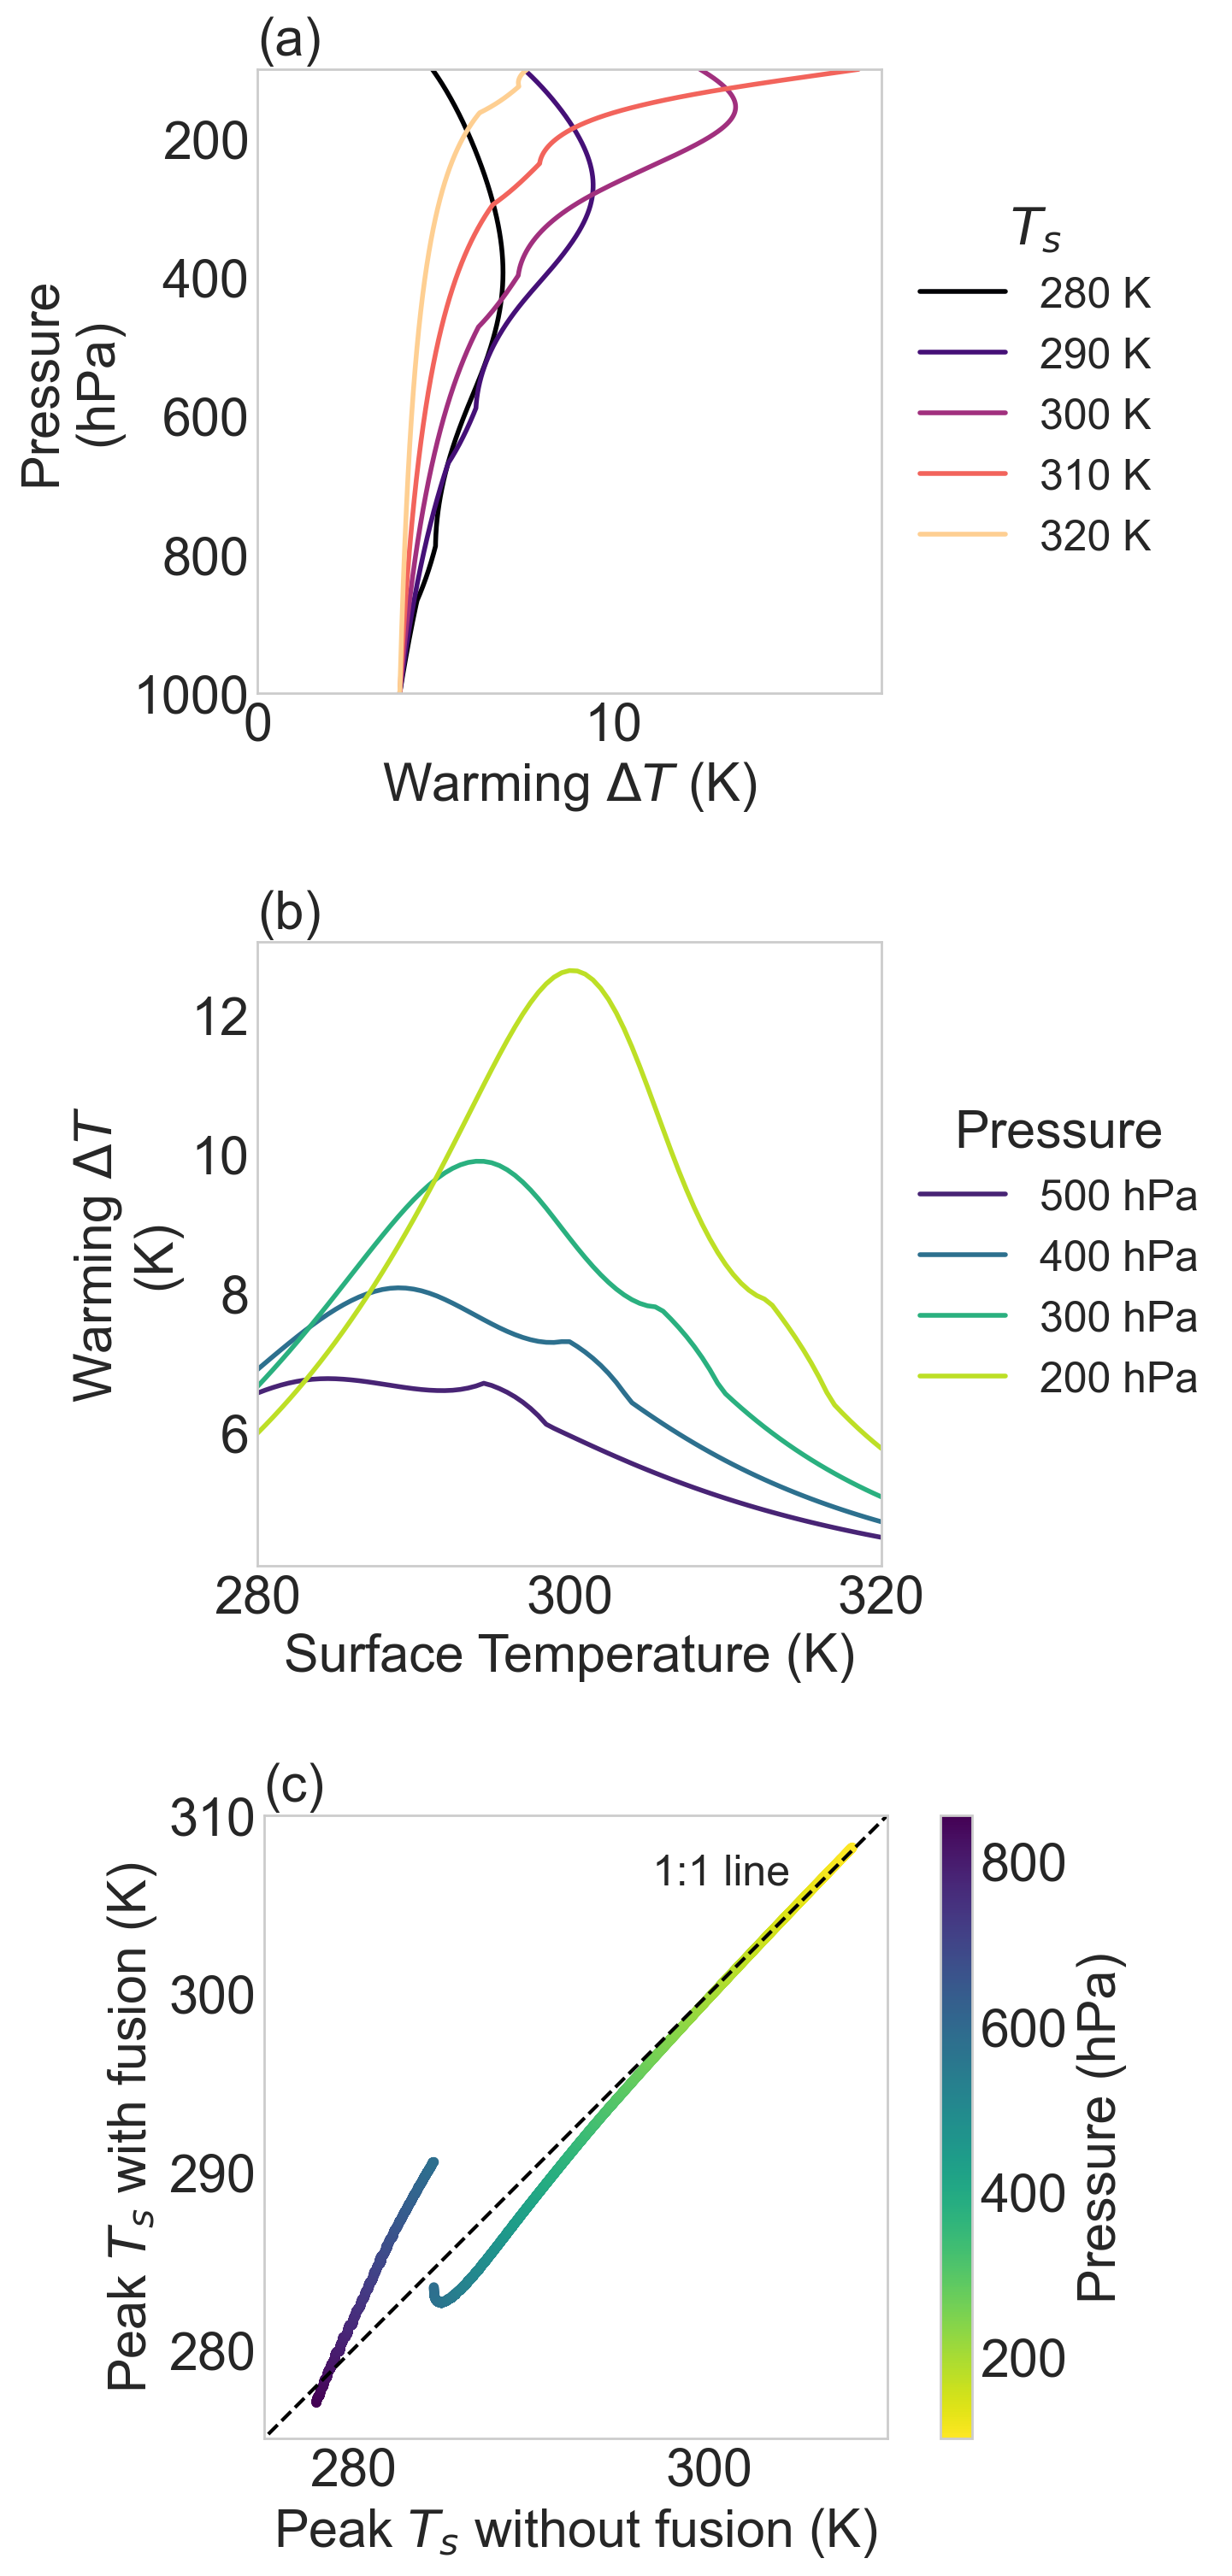

Figure B1 saved as fig-b1.png

Script finished.


In [2]:
# --- Plotting Figure B1 ---
print("--- Generating Figure B1 ---")
plt.style.use('seaborn-v0_8-whitegrid')
base_fontsize = 22
plt.rcParams.update({
    'font.size': base_fontsize,
    'axes.titlesize': base_fontsize,
    'axes.labelsize': base_fontsize,
    'xtick.labelsize': base_fontsize,
    'ytick.labelsize': base_fontsize,
    'legend.fontsize': base_fontsize-4,
    'figure.titlesize': base_fontsize + 2
})

fig, axes = plt.subplots(3, 1, figsize=(8, 18))
cmap_b = plt.get_cmap('magma')
cmap_c = plt.get_cmap('viridis')
p_hpa_grid = p_grid / 100.0

# Panel (a): Vertical Warming Profiles vs. Pressure (with fusion)
ax1 = axes[0]
T_plot_values = np.arange(280, 320.1, 10.0)
colors_b = cmap_b(np.linspace(0, 0.9, len(T_plot_values)))
for i, T_surf in enumerate(T_plot_values):
    if T_surf in delta_T_on_p_with:
        ax1.plot(delta_T_on_p_with[T_surf], p_hpa_grid, color=colors_b[i], label=f'{T_surf:.0f} K', linewidth=2)
ax1.set_xlabel('Warming $\Delta T$ (K)')
ax1.set_ylabel('Pressure\n(hPa)')
ax1.set_ylim(100, 1000)
ax1.set_title('(a)', ha='left', x=0)
ax1.legend(title='$T_{s}$', loc='center left', bbox_to_anchor=(1, 0.5))
ax1.grid(False); ax1.set_xlim(left=0); ax1.set_box_aspect(1); ax1.invert_yaxis()

# Panel (b): Non-Monotonic Warming at Fixed Pressure Levels (with fusion)
ax2 = axes[1]
p_levels_hpa = [500, 400, 300, 200]
colors_c = cmap_c(np.linspace(0.1, 0.9, len(p_levels_hpa)))
for i, p_hpa in enumerate(p_levels_hpa):
    p_idx = np.argmin(np.abs(p_hpa_grid - p_hpa))
    valid_surfs = [T for T in sorted_surfs if T in delta_T_on_p_with and p_idx < len(delta_T_on_p_with[T]) and np.isfinite(delta_T_on_p_with[T][p_idx])]
    warming_at_p = [delta_T_on_p_with[T][p_idx] for T in valid_surfs]
    ax2.plot(valid_surfs, warming_at_p, linestyle='-', color=colors_c[i], label=f'{p_hpa} hPa', linewidth=2)
ax2.set_xlabel('Surface Temperature (K)')
ax2.set_ylabel('Warming $\Delta T$\n(K)')
ax2.set_title('(b)', ha='left', x=0)
ax2.legend(title='Pressure', loc='center left', bbox_to_anchor=(1, 0.5))
ax2.grid(False); ax2.set_xlim(280, 320); ax2.set_box_aspect(1)

# Panel (c): Peak T_s without vs. with fusion, colored by pressure
ax3 = axes[2]
valid_idx = ~np.isnan(peak_Ts_no) & ~np.isnan(peak_Ts_with) & (p_hpa_grid <= 990)
p_hpa_valid = p_hpa_grid[valid_idx]
x = peak_Ts_no[valid_idx]
y = peak_Ts_with[valid_idx]
ax3.plot([270, 320], [270, 320], 'k--', label='1:1 line     ')
sc = ax3.scatter(x, y, c=p_hpa_valid, cmap='viridis_r', s=10)
ax3.set_xlabel('Peak $T_{s}$ without fusion (K)')
ax3.set_ylabel('Peak $T_{s}$ with fusion (K)')
ax3.set_title('(c)', ha='left', x=0)
ax3.set_xlim(275, 310)
ax3.set_ylim(275, 310)
ax3.grid(False)
ax3.set_box_aspect(1)
ax3.legend(frameon=False, loc='upper right', handletextpad=0.5, handlelength=0)
cbar = fig.colorbar(sc, ax=ax3, label='Pressure (hPa)')

plt.subplots_adjust(hspace=0.4)
filename = "fig-b1.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure B1 saved as {filename}")
print("\nScript finished.")


In [3]:
print(np.max(np.abs(x-y)))
print(p_hpa_grid[np.argmax(np.abs(x-y))])

6.0263211115464514
727.1
